In [36]:
from scipy.io import loadmat
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
import copy
from pathlib import Path
import yaml
import os
import sys

In [39]:
# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
#proj_path = current_dir.parent
proj_path = current_dir.parent
# make the code in src available to import in this notebook
sys.path.append(os.path.join(proj_path, 'src'))

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/data_catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)

# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/parameters.yml'), "r") as f:
    params = yaml.safe_load(f)


# Import Dataset

In [30]:
with open('../data/02_interim/bmodes_steatosis_assessment_IJCARS.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [3]:
M, N= 434, 636 # ultrasound image dimension

In [28]:
def create_cumul_var_graph(pca, J= None):
    ratio = pca.explained_variance_ratio_
    cumulative = np.cumsum(ratio)
    n_components = np.arange(0, len(cumulative))
    if J is None:
        plt.plot(n_components, cumulative,label= "Raw US" )
        plt.title("Cumulative Explained Variance by number of components")
    else:
        plt.plot(n_components, cumulative,label= f'J:{J}' )
        plt.title(f"Cumulative Explained Variance by number of components ")
    plt.ylabel("Cumulative Ratio")
    plt.xlabel("Number of components")
    plt.legend()

    

## 1. Visualization of Raw US images (No transformation)

In [61]:
# Reshape the data appropriately
data = df['img'].iloc[0].view(1,M*N)
for i in tqdm(range(1,len(df['img']))):
    data = torch.cat([data,df['img'].iloc[i].view(1,M*N)])

100%|██████████| 549/549 [00:07<00:00, 70.69it/s] 


## 1. Visulalization GLOBAL PCA - Scattering Transform

  0%|          | 0/5 [00:00<?, ?it/s]

2
Scattering loaded
(550, 1390932)
PCA started


  0%|          | 0/5 [00:13<?, ?it/s]


KeyboardInterrupt: 

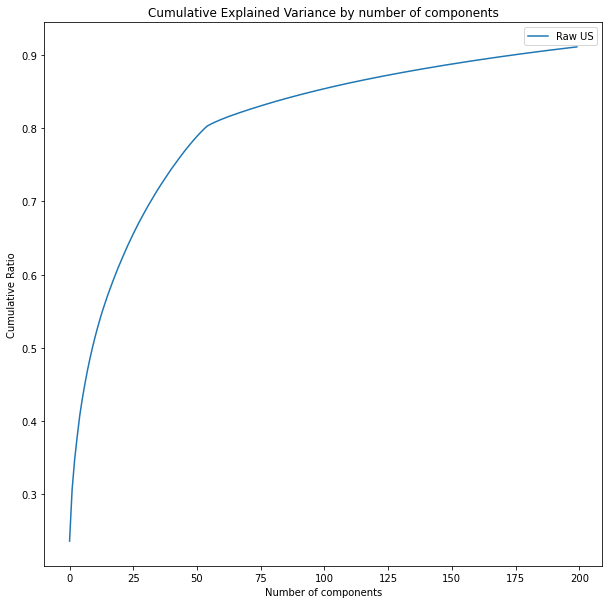

In [63]:
plt.figure(figsize=(10,10))
pca = PCA(n_components=200)
pca.fit(data)
pca_data = pca.transform(data)
create_cumul_var_graph(pca)
for J in tqdm(range(2,7)):
    print(J)
    with open(f'../data/03_features/scattering_features_J_{J}.pickle', 'rb') as handle:
        scatter_dict = pickle.load(handle)
        df_scattering = scatter_dict['df']
        scattering_params = {'J':scatter_dict['J'],
                         'M':scatter_dict['M'],
                         'N':scatter_dict['N']}
    print("Scattering loaded")
    #Transforming df_scattering to a numpy array excluding class and id
    df_scattering.drop("class", inplace = True, axis=1)
    df_scattering.drop("id", inplace=True, axis=1)
    print(df_scattering.shape)
    df_scattering = df_scattering.to_numpy()
    print("PCA started")
    pca_s = PCA(n_components=200)
    pca_data_s = pca_s.fit_transform(df_scattering)
    create_cumul_var_graph(pca_s, J)


# 2. def get_scattering_features(catalog, J):


In [43]:
def get_scattering_features(catalog, J):
    with open(os.path.join(catalog['data_root'], catalog[f'03_feature_scatt_{J}']), 'rb') as handle:
        scatter_dict = pickle.load(handle)
        df_scattering = scatter_dict['df']
        scattering_params = {'J':scatter_dict['J'],
                            'M':scatter_dict['M'],
                            'N':scatter_dict['N']}
    df_scattering = df_scattering.drop(columns=['id', 'class'])
    return df_scattering, scattering_params

In [44]:
with open('../data/02_interim/bmodes_steatosis_assessment_IJCARS.pickle', 'rb') as handle:
    df = pickle.load(handle)

  0%|          | 0/5 [00:00<?, ?it/s]

2
Scattering loaded
Size datase: (550, 1390932)
PCA started


 20%|██        | 1/5 [00:24<01:36, 24.02s/it]

3
Scattering loaded
Size datase: (550, 925722)
PCA started


 40%|████      | 2/5 [00:57<01:28, 29.58s/it]

4
Scattering loaded
Size datase: (550, 439101)
PCA started


 60%|██████    | 3/5 [01:07<00:41, 20.61s/it]

5
Scattering loaded
Size datase: (550, 168207)
PCA started


 80%|████████  | 4/5 [01:09<00:13, 13.45s/it]

6
Scattering loaded
Size datase: (550, 54486)
PCA started


100%|██████████| 5/5 [01:10<00:00, 14.15s/it]


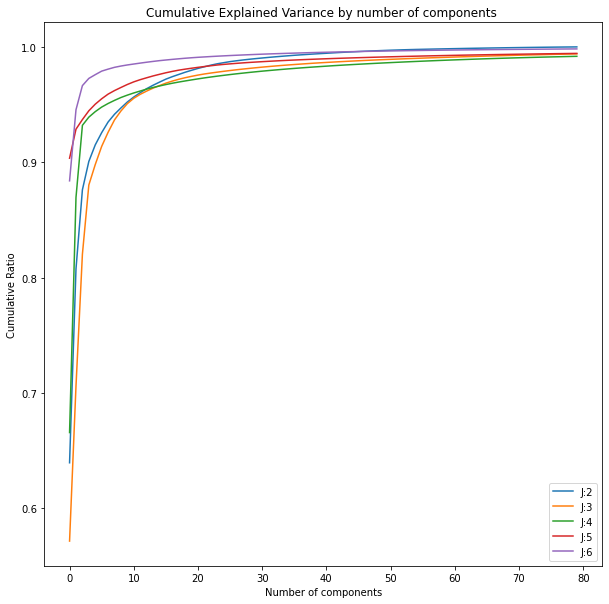

In [75]:
plt.figure(figsize=(10,10))
for J in tqdm(range(2,7)):
    print(J)
    data, _ = get_scattering_features(catalog, J)
    print("Scattering loaded")
    dataset = pd.concat([df, data], axis=1)
    subtrain_data_flatten = dataset.drop(['img','fat', 'class', 'id'], axis=1)
    
    size = len(subtrain_data_flatten)
    print(f"Size datase: {subtrain_data_flatten.shape}")
    if J  == 2:
        subtrain_data_flatten = torch.from_numpy(subtrain_data_flatten.values).view(size,108,159,81)
        subtrain_data_flatten = subtrain_data_flatten.reshape(-1,81)
        nm_component = 81
    elif J==3:
        subtrain_data_flatten = torch.from_numpy(subtrain_data_flatten.values).view(size,54,79,217)
        subtrain_data_flatten = subtrain_data_flatten.reshape(-1,217)
        nm_component = 100
    elif J==4:
        subtrain_data_flatten = torch.from_numpy(subtrain_data_flatten.values).view(size,27,39,417)
        subtrain_data_flatten = subtrain_data_flatten.reshape(-1,417)
        nm_component = 100
    elif J==5:
        subtrain_data_flatten = torch.from_numpy(subtrain_data_flatten.values).view(size,13,19,681)
        subtrain_data_flatten = subtrain_data_flatten.reshape(-1,681)
        nm_component = 100
    elif J==6:
        subtrain_data_flatten = torch.from_numpy(subtrain_data_flatten.values).view(size,6,9,1009)
        subtrain_data_flatten = subtrain_data_flatten.reshape(-1,1009)
        nm_component = 100
    else:
        raise NotImplemented(f"J {self.J} parameter for scattering not implemented")

    
    print("PCA started")
    pca_s = PCA(n_components=80)
    pca_data_s = pca_s.fit_transform(subtrain_data_flatten)
    create_cumul_var_graph(pca_s, J)



In [58]:
torch.from_numpy(subtrain_data_flatten.values).shape


torch.Size([550, 1390934])